In [ ]:
#hide
from chitra.core import *

# Chitra

> Library for creating data input pipeline in pure Tensorflow 2.x

#hide
<!-- This file will become your README and also the index of your documentation. -->

## Install

`pip install chitra`

## How to use

<!-- Fill me in please! Don't forget code examples: -->
## Loading data for image classification

CLASSES FOUND: ('blackcat', 'whitecat')
CLASSES ENCODED AS {'blackcat': 0, 'whitecat': 1}


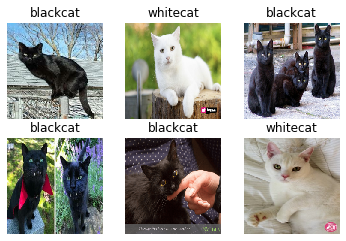

In [ ]:
import tensorflow as tf
import chitra
from chitra.dataloader import Clf, show_batch

path = '/Users/aniketmaurya/Pictures/cats'

clf_dl = Clf()
data = clf_dl.from_folder(path, target_shape=(224, 224))

show_batch(clf_dl, limit=6, figsize=(6,6))